## State Agregation e Linear Aproximation com Semi-Gradient Temporal Difference

### Envirorment

* N estados não terminais $S+ = {s1, s2, ..., sN}$, onde $N >= 500$
* Duas ações deterministicas em cada estado (direita ou esquerda) $A(S) = {0, 1}$ onde `0 = esquerda` e `1 = direita`
* Uma ação para um dos lados leva o agente para umas dos 100 estados seguintes naquela direção
* Se houverem menos de 100 estados até um dos $ST$ então qualquer estado posterior ao $ST$ termina no $ST$
* Uniform Random Policy $\pi(.|s) = 0.5$ para todo $s$ pertencente a $S$
* Os episodios começam no estado ${|S+|/2}$
* Todos os episodios terminam ao serem atingidos a extremidade esquerda($L$) ou direita($D$)
* $S = {L, s1, s2, s3, ..., sN, D}$
* Os rewards sõ 0 para todas as transições exceto na que leva de $sN$ para $D$, onde o reward é $+1$ e para o $E$, onde o reward é $-1$
* Os estados estarão divididos em $K$ grupos com $N/K$ estados cada

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MyEnv:
    def __init__(self, N, init_state = None):
        self.N = N
        self.terminal = None
        if not init_state:
            self.init_state = int(self.N/2)
        else:
            self.init_state = init_state
        
        self.L = 0
        self.R = self.N + 1
        
        self.L_reward = -1
        self.R_reward = 1
        self.t_reward = 0
    #------------------------------------------------------
    def init(self):
        self.terminal = False
        self.state = self.init_state
        return self.state, self.terminal
    #------------------------------------------------------
    def step(self, action):
        if(self.terminal == False):
            #action = 0 -> ESQUERDA
            if(action == 0): 
                self.state = self.state - (np.random.randint(100) + 1)
                reward = self.t_reward
            
            #action = 1 -> DIREITA
            elif(action == 1):
                self.state = self.state + (np.random.randint(100) + 1)
                reward = self.t_reward
            
            #Se chegar no L
            if(self.state <= self.L):
                self.state = self.L
                reward = self.L_reward
                self.terminal = True
            
            #Se chegar no R
            elif(self.state >= self.R):
                self.state = self.R
                reward = self.R_reward
                self.terminal = True
        
        else:
            reward = self.t_reward
            self.terminal = True
        
        return self.state, reward, self.terminal
    #------------------------------------------------------    
    def getNStates(self):
        return self.N
    #------------------------------------------------------    
    def getNActions(self):
        return 2

In [3]:
class Agent:
    def __init__(self, num_groups, step_size, discount):
        self.num_groups = num_groups
        self.weights = np.random.rand((self.num_groups))
        self.step_size = step_size
        self.discount = discount
        
    def train(self, env, num_episodes):
        num_states = env.getNStates()
        self.states_per_group = int(num_states/self.num_groups)
        
        self.q_values = np.zeros((num_states))
        
        for episode in range(num_episodes):
            prev_state, terminal = env.init()
            prev_action = np.random.randint(env.getNActions())
            
            while(terminal == False):
                prev_features = self.getFeatures(prev_state)
                
                state, reward, terminal = env.step(prev_action)
                
                if(terminal == False):
                    features = self.getFeatures(state)
                else:
                    features = np.zeros((self.num_groups))
                
                t_error = (reward + self.discount*np.dot(self.weights, features) - np.dot(self.weights, prev_features)) 
                self.weights += self.step_size*np.dot(t_error, prev_features)
                
                prev_state = state
                prev_action = np.random.randint(env.getNActions())
            
        for i in range(1, num_states + 1):   
            self.q_values[i - 1] = np.dot(self.weights, self.getFeatures(i))
        return self.q_values
    
    def getFeatures(self, state):
        features = np.zeros((self.num_groups))
        features[int((state - 1)/self.states_per_group)] = 1
        return features

In [4]:
N = 1000
num_groups = 10
t = np.arange(1, N + 1)
env = MyEnv(N=N, init_state=500)
agent1 = Agent(num_groups=num_groups, step_size=0.01, discount=1)
agent2 = Agent(num_groups=num_groups, step_size=0.1, discount=1)
agent3 = Agent(num_groups=num_groups, step_size=0.5, discount=1)

In [5]:
q1 = agent1.train(env, 10000)
q2 = agent2.train(env, 10000)
q3 = agent3.train(env, 10000)

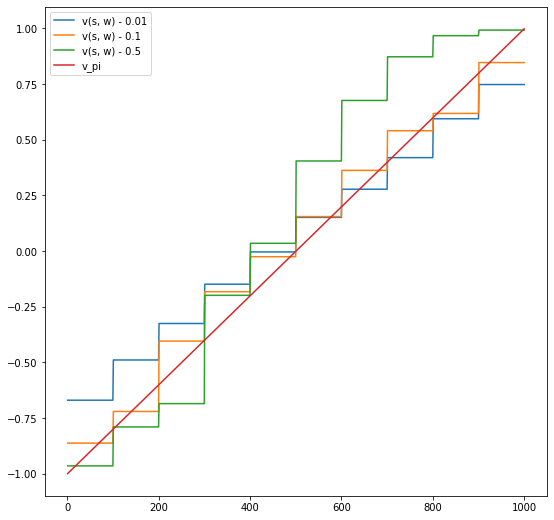

In [6]:
plt.figure(figsize=(9, 9))
plt.plot(t, q1, label="v(s, w) - 0.01")
plt.plot(t, q2, label="v(s, w) - 0.1")
plt.plot(t, q3, label="v(s, w) - 0.5")
plt.plot(t, np.arange(-1, 1, (2/N)), label="v_pi")
plt.legend()